In [72]:
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import lightgbm as lgb
import shap
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression, RidgeClassifier, LinearRegression 
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, confusion_matrix,roc_auc_score, recall_score, precision_score, f1_score, cohen_kappa_score, matthews_corrcoef, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier

In [30]:
data = sm.datasets.get_rdataset('GaltonFamilies', package='HistData').data

In [31]:
print(data.head())

  family  father  mother  midparentHeight  children  childNum  gender  \
0    001    78.5    67.0            75.43         4         1    male   
1    001    78.5    67.0            75.43         4         2  female   
2    001    78.5    67.0            75.43         4         3  female   
3    001    78.5    67.0            75.43         4         4  female   
4    002    75.5    66.5            73.66         4         1    male   

   childHeight  
0         73.2  
1         69.2  
2         69.0  
3         69.0  
4         73.5  


In [55]:
# Define features (X) and target variable (y)
X = data[['father', 'mother', 'midparentHeight', 'childHeight']]
y = data['gender']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Display classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.88
              precision    recall  f1-score   support

      female       0.89      0.86      0.88        95
        male       0.86      0.89      0.88        92

    accuracy                           0.88       187
   macro avg       0.88      0.88      0.88       187
weighted avg       0.88      0.88      0.88       187



In [70]:
# Preprocessing the data
X = data[['father', 'mother']].values
y = data['childHeight'].values  # Corrected column name

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating the decision tree regressor
tree_reg = DecisionTreeRegressor(random_state=42)

# Training the decision tree model
tree_reg.fit(X_train, y_train)

# Making predictions with the decision tree model
y_pred_tree = tree_reg.predict(X_test)

# Evaluating the decision tree model
mse_tree = mean_squared_error(y_test, y_pred_tree)
print("Decision Tree Mean Squared Error:", mse_tree)

# Initialize and train the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Making predictions with the linear regression model
y_pred_linear = linear_model.predict(X_test)

# Evaluating the linear regression model
mse_linear = mean_squared_error(y_test, y_pred_linear)
print("Linear Regression Mean Squared Error:", mse_linear)

Decision Tree Mean Squared Error: 12.732089683933026
Linear Regression Mean Squared Error: 10.744255759132194


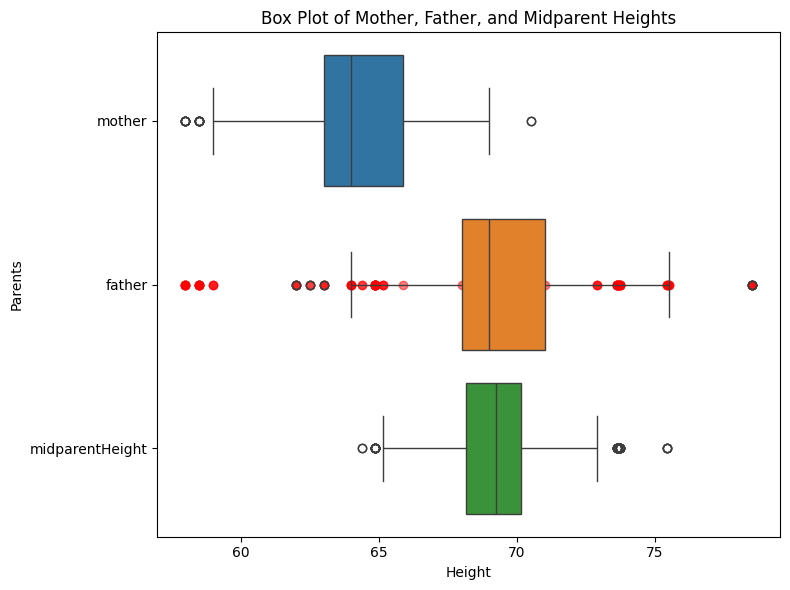

In [33]:
# Select 'mother', 'father', and 'midparentHeight' features
X = data[['mother', 'father', 'midparentHeight']]

# Create a box plot for the selected features
plt.figure(figsize=(8, 6))
boxplot = sns.boxplot(data=X, orient="h")

# Find the outliers
outliers = [flier.get_data()[0] for flier in boxplot.get_children() if isinstance(flier, plt.Line2D)]

# Change outlier style to dots
for points in outliers:
    plt.scatter(points, [1] * len(points), marker='o', color='r', alpha=0.5)  # Fixed the y-coordinate to 1

plt.title("Box Plot of Mother, Father, and Midparent Heights")
plt.xlabel("Height")
plt.ylabel("Parents")
plt.tight_layout()
plt.show()


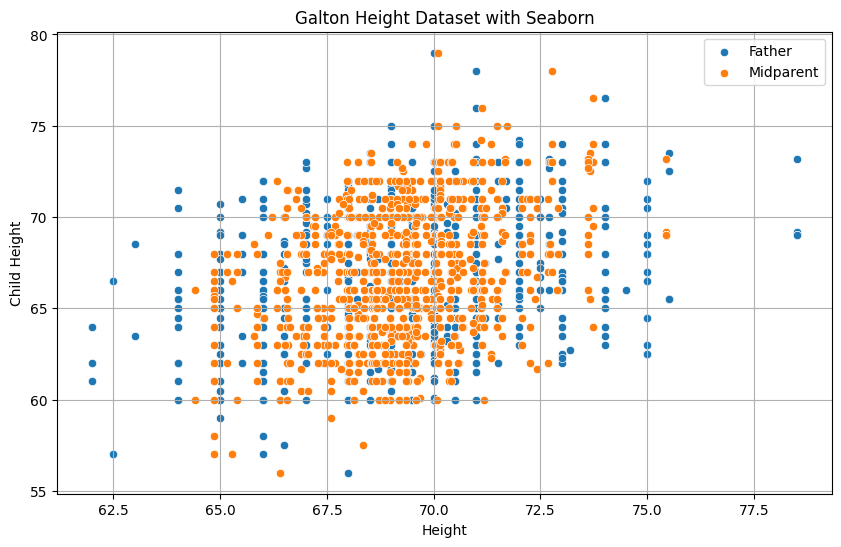

In [34]:
# Plot the heights of fathers and sons using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='father', y='childHeight', label='Father')
sns.scatterplot(data=data, x='midparentHeight', y='childHeight', label='Midparent')
plt.xlabel('Height')
plt.ylabel('Child Height')
plt.title('Galton Height Dataset with Seaborn')
plt.legend()
plt.grid(True)
plt.show()

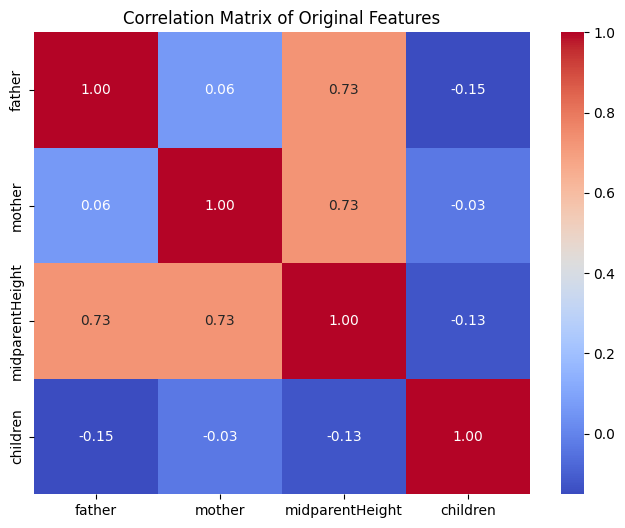

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1000x600 with 0 Axes>

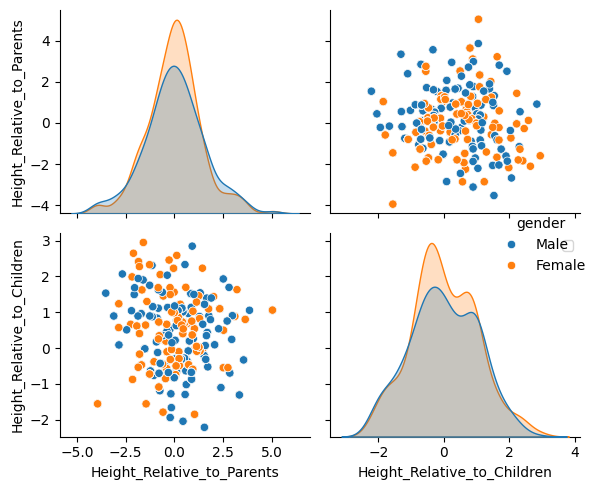

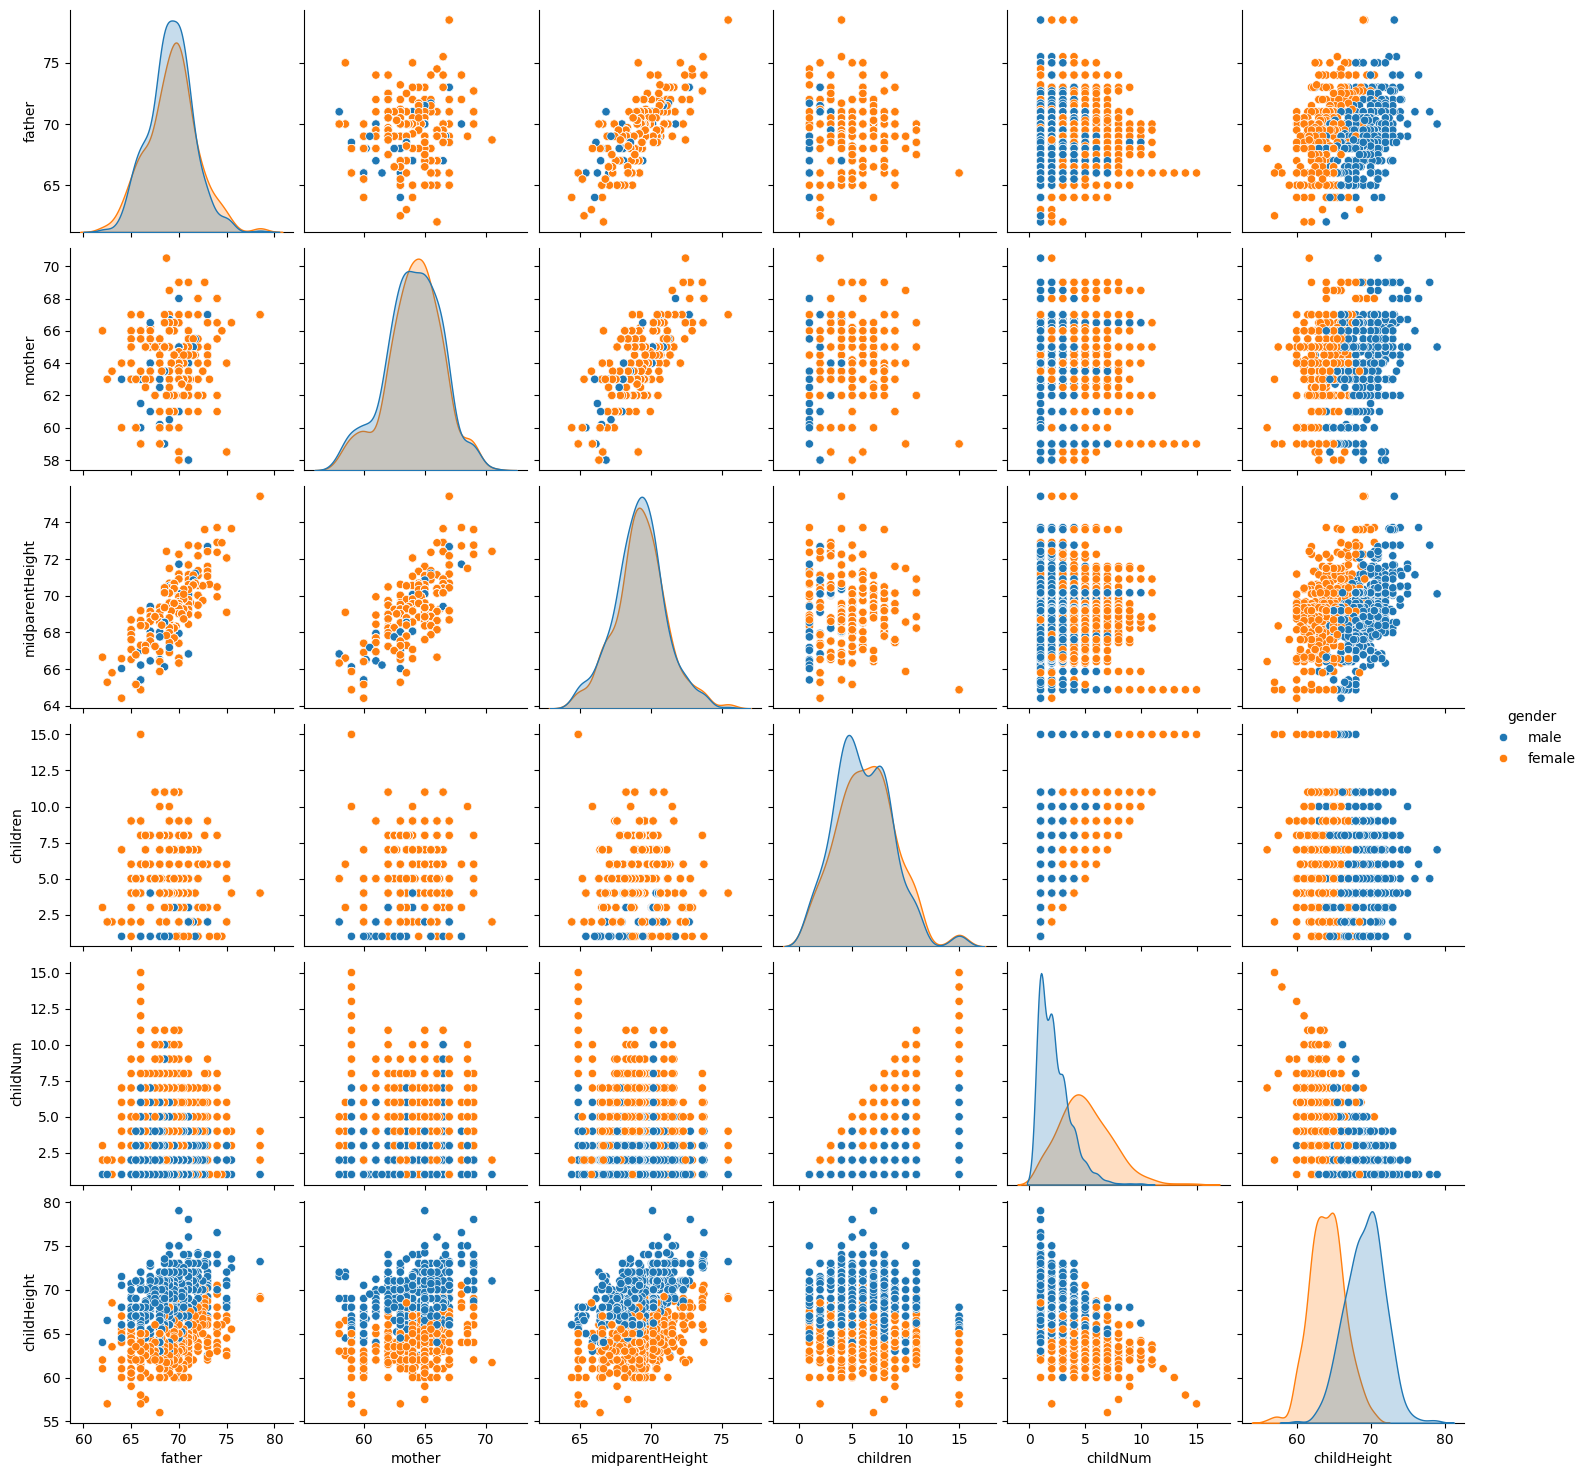

In [73]:
# Selecting relevant features and standardizing the data
X = data[['father', 'mother', 'midparentHeight', 'children']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

# Get the principal component loadings
loadings = pca.components_

# Create a DataFrame for the PCA results with real feature names
pca_df = pd.DataFrame(data=pca_result, columns=['Height_Relative_to_Parents', 'Height_Relative_to_Children'])

# Calculate the correlation matrix from the original standardized data
correlation_matrix = pd.DataFrame(X_scaled, columns=['father', 'mother', 'midparentHeight', 'children']).corr()

# Adding a dummy 'gender' column to pca_df for demonstration purposes
# This column is added with random gender labels for demonstration
gender_labels = ['Male', 'Female']
pca_df['gender'] = [random.choice(gender_labels) for _ in range(len(pca_df))]

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Matrix of Original Features')
plt.show()

# Plot the pair plot
plt.figure(figsize=(10, 6))
pairplot = sns.pairplot(pca_df, hue='gender')  # Using 'gender' as hue
pairplot.fig.subplots_adjust(top=0.9)  # Adjust top margin to make space for legend
plt.legend(loc='upper right', bbox_to_anchor=(1, 1))  # Move legend to top right corner
plt.tight_layout()  # Adjusts subplot parameters
plt.show()

pairplot = sns.pairplot(data, hue='gender')

In [36]:
# Select relevant features
X = data[['father', 'mother', 'midparentHeight']]

# Compute the covariance matrix
cov_matrix = np.cov(X.T)

# Perform eigen decomposition
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Display eigenvalues and eigenvectors
print("Eigenvalues:")
print(eigenvalues)
print("\nEigenvectors:")
print(eigenvectors)

Eigenvalues:
[3.55271368e-15 9.33186337e+00 5.29778451e+00]

Eigenvectors:
[[ 0.40270234 -0.64807207  0.64640035]
 [ 0.43491853 -0.48590809 -0.75811556]
 [-0.80540468 -0.5864264  -0.08618223]]


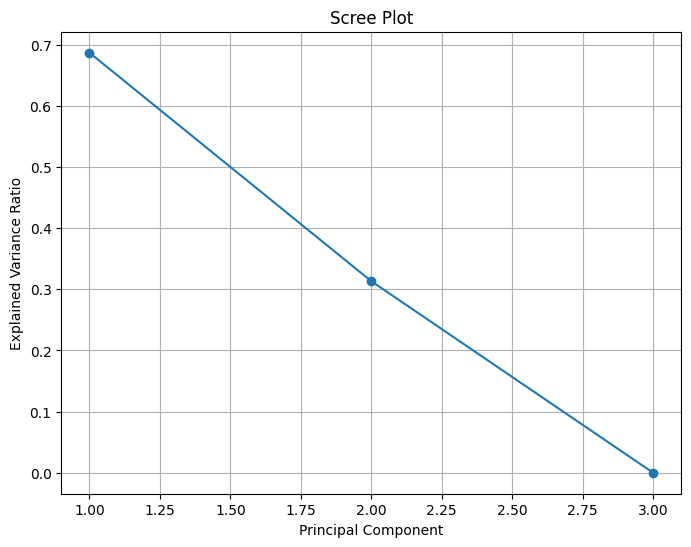

In [37]:
# Select features for PCA
X = data[['mother', 'father', 'midparentHeight']]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Plot scree plot
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o', linestyle='-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

In [38]:
# Select features for PCA
X = data[['mother', 'father', 'midparentHeight', 'children', 'childNum', 'childHeight']]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=2)  # We choose 2 principal components for visualization
X_pca = pca.fit_transform(X_scaled)

# Get the principal component loadings (coefficients)
pc_loadings = pca.components_.T  # Transpose to match the shape of original features

# Extract coefficients for the first principal component (PC1)
a1, b1, c1, d1, e1, f1 = pc_loadings[:, 0]

# Extract coefficients for the second principal component (PC2)
a2, b2, c2, d2, e2, f2 = pc_loadings[:, 1]

print("Coefficients for the first principal component (PC1):")
print(f"a1: {a1}, b1: {b1}, c1: {c1}, d1: {d1}, e1: {e1}, f1: {f1}")

print("\nCoefficients for the second principal component (PC2):")
print(f"a2: {a2}, b2: {b2}, c2: {c2}, d2: {d2}, e2: {e2}, f2: {f2}")

Coefficients for the first principal component (PC1):
a1: -0.3637817987519239, b1: -0.42162941405878385, c1: -0.5393480831850646, d1: 0.2846877478698888, e1: 0.3615338498841408, f1: -0.4327138163527708

Coefficients for the second principal component (PC2):
a2: 0.3848682543581621, b2: 0.22124077160929412, c2: 0.41615277066807255, d2: 0.4529443737686077, e2: 0.5970450018657528, f2: -0.2610066651424794


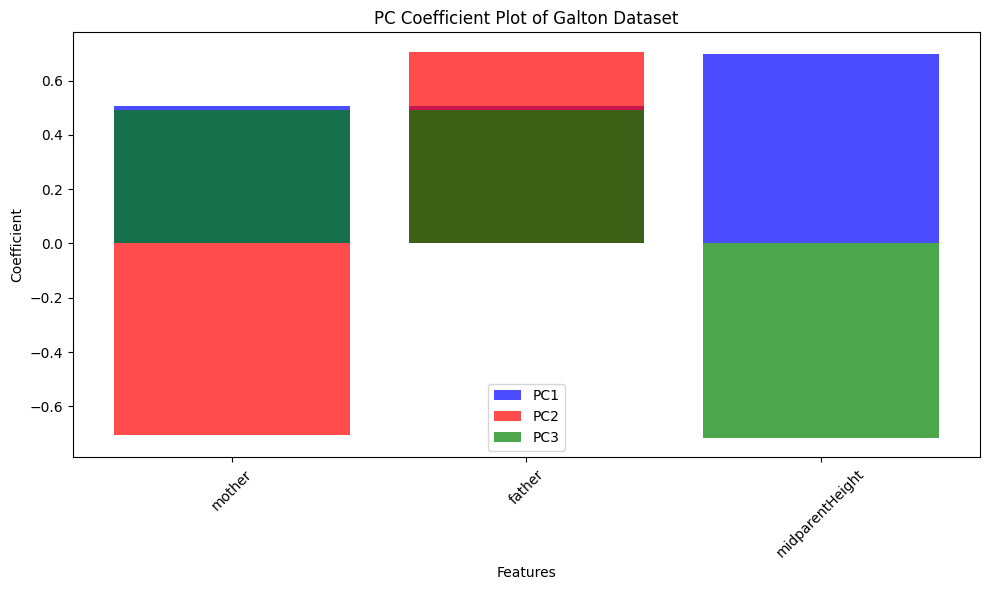

In [39]:
# Select features for PCA
X = data[['mother', 'father', 'midparentHeight']]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Extract the coefficients
coefficients = pca.components_

# Plot the coefficients
plt.figure(figsize=(10, 6))
plt.bar(range(len(coefficients)), coefficients[0], color='blue', alpha=0.7, label='PC1')
plt.bar(range(len(coefficients)), coefficients[1], color='red', alpha=0.7, label='PC2')
plt.bar(range(len(coefficients)), coefficients[2], color='green', alpha=0.7, label='PC3')
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.title('PC Coefficient Plot of Galton Dataset')
plt.legend()
plt.xticks(range(len(X.columns)), X.columns, rotation=45)
plt.tight_layout()
plt.show()

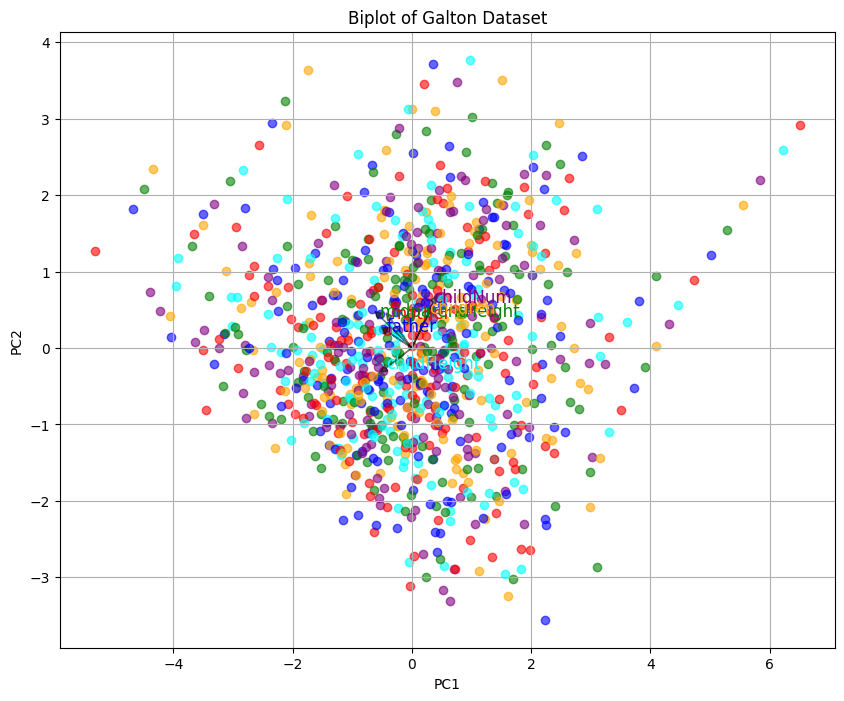

In [40]:
# Select features for PCA
X = data[['mother', 'father', 'midparentHeight', 'children', 'childNum', 'childHeight']]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=2)  # We choose 2 principal components for visualization
X_pca = pca.fit_transform(X_scaled)

# Get the principal component loadings (coefficients)
pc_loadings = pca.components_.T  # Transpose to match the shape of original features

# Define colors for each feature
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']

# Plot the biplot with different colors for data points
plt.figure(figsize=(10, 8))
for i, (pc1, pc2) in enumerate(zip(X_pca[:, 0], X_pca[:, 1])):
    plt.scatter(pc1, pc2, color=colors[i % len(colors)], alpha=0.6)  # Use modulo to cycle through colors

# Plot the feature vectors as arrows with black color and larger size
for i, (pc1, pc2) in enumerate(zip(pc_loadings[:, 0], pc_loadings[:, 1])):
    plt.arrow(0, 0, pc1, pc2, color='black', alpha=0.5, head_width=0.1, head_length=0.1)  # Increase head size
    plt.text(pc1, pc2, X.columns[i], color=colors[i], fontsize=12)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Biplot of Galton Dataset')
plt.grid(True)
plt.show()

In [41]:
# Split the data into features and target
X = data.drop(columns=['family', 'gender'])
y = data['gender']

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Initialize classifiers
classifiers = {
    'ida': DecisionTreeClassifier(),
    'et': ExtraTreesClassifier(),
    'gbc': GradientBoostingClassifier(),
    'qda': QuadraticDiscriminantAnalysis(),
    'lightgbm': lgb.LGBMClassifier(),
    'rf': RandomForestClassifier(),
    'ada': AdaBoostClassifier(),
    'dt': DecisionTreeClassifier(),
    'lr': LogisticRegression(),
    'ridge': RidgeClassifier(),
    'nb': GaussianNB(),
    'knn': KNeighborsClassifier(),
    'svm': SVC(),
    'dummy': DummyClassifier(strategy='most_frequent')  # Choose appropriate strategy
}

# Dictionary to store metrics
metrics = {
    'Model': [],
    'Accuracy': [],
    'AUC': [],
    'Recall': [],
    'Precision': [],
    'F1': [],
    'Kappa': [],
    'MCC': [],
    'TT(sec)': []
}

# Train and evaluate classifiers
for name, clf in classifiers.items():
    start_time = time.time()
    pipe = make_pipeline(StandardScaler(), clf)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    # Append metrics to the dictionary
    metrics['Model'].append(name)
    metrics['Accuracy'].append(accuracy)
    metrics['AUC'].append(auc)
    metrics['Recall'].append(recall)
    metrics['Precision'].append(precision)
    metrics['F1'].append(f1)
    metrics['Kappa'].append(kappa)
    metrics['MCC'].append(mcc)
    metrics['TT(sec)'].append(elapsed_time)

# Create a DataFrame from the metrics dictionary
metrics_df = pd.DataFrame(metrics)

# Display the metrics table
print(metrics_df)

c:\Users\Pooria\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


[LightGBM] [Info] Number of positive: 389, number of negative: 358
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 234
[LightGBM] [Info] Number of data points in the train set: 747, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.520750 -> initscore=0.083046
[LightGBM] [Info] Start training from score 0.083046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

c:\Users\Pooria\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


       Model  Accuracy       AUC    Recall  Precision        F1     Kappa  \
0        ida  0.812834  0.814416  0.913043   0.756757  0.827586  0.626789   
1         et  0.919786  0.919851  0.923913   0.913978  0.918919  0.839558   
2        gbc  0.893048  0.893364  0.913043   0.875000  0.893617  0.786188   
3        qda  0.882353  0.882151  0.869565   0.888889  0.879121  0.764564   
4   lightgbm  0.887701  0.888101  0.913043   0.865979  0.888889  0.775536   
5         rf  0.909091  0.908982  0.902174   0.912088  0.907104  0.818104   
6        ada  0.866310  0.866362  0.869565   0.860215  0.864865  0.732597   
7         dt  0.823529  0.824600  0.891304   0.780952  0.832487  0.647754   
8         lr  0.903743  0.903547  0.891304   0.911111  0.901099  0.807371   
9      ridge  0.903743  0.903547  0.891304   0.911111  0.901099  0.807371   
10        nb  0.828877  0.828661  0.815217   0.833333  0.824176  0.657548   
11       knn  0.887701  0.887586  0.880435   0.890110  0.885246  0.775305   

In [51]:
# Split the data into features and target
X = data.drop(columns=['family', 'gender'])
y = data['gender']

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Apply PCA
pca = PCA(n_components='mle', svd_solver='full')
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Initialize classifiers
classifiers = {
    'ida': DecisionTreeClassifier(),
    'et': ExtraTreesClassifier(),
    'gbc': GradientBoostingClassifier(),
    'qda': QuadraticDiscriminantAnalysis(),
    'lightgbm': lgb.LGBMClassifier(),
    'rf': RandomForestClassifier(),
    'ada': AdaBoostClassifier(),
    'dt': DecisionTreeClassifier(),
    'lr': LogisticRegression(),
    'ridge': RidgeClassifier(),
    'nb': GaussianNB(),
    'knn': KNeighborsClassifier(),
    'svm': SVC(),
    'dummy': DummyClassifier(strategy='most_frequent')  # Choose appropriate strategy
}

# Dictionary to store metrics
metrics = {
    'Model': [],
    'Accuracy': [],
    'AUC': [],
    'Recall': [],
    'Precision': [],
    'F1': [],
    'Kappa': [],
    'MCC': [],
    'TT(sec)': []
}

# Train and evaluate classifiers
for name, clf in classifiers.items():
    start_time = time.time()
    pipe = make_pipeline(StandardScaler(), clf)
    pipe.fit(X_train_pca, y_train)
    y_pred = pipe.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    # Append metrics to the dictionary
    metrics['Model'].append(name)
    metrics['Accuracy'].append(accuracy)
    metrics['AUC'].append(auc)
    metrics['Recall'].append(recall)
    metrics['Precision'].append(precision)
    metrics['F1'].append(f1)
    metrics['Kappa'].append(kappa)
    metrics['MCC'].append(mcc)
    metrics['TT(sec)'].append(elapsed_time)

# Create a DataFrame from the metrics dictionary
metrics_df = pd.DataFrame(metrics)

# Display the metrics table
print(metrics_df)

[LightGBM] [Info] Number of positive: 389, number of negative: 358
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1248
[LightGBM] [Info] Number of data points in the train set: 747, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.520750 -> initscore=0.083046
[LightGBM] [Info] Start training from score 0.083046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

c:\Users\Pooria\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


       Model  Accuracy       AUC    Recall  Precision        F1     Kappa  \
0        ida  0.903743  0.903719  0.902174   0.902174  0.902174  0.807437   
1         et  0.925134  0.924943  0.913043   0.933333  0.923077  0.850177   
2        gbc  0.919786  0.919508  0.902174   0.932584  0.917127  0.839448   
3        qda  0.882353  0.882151  0.869565   0.888889  0.879121  0.764564   
4   lightgbm  0.919786  0.919508  0.902174   0.932584  0.917127  0.839448   
5         rf  0.919786  0.919508  0.902174   0.932584  0.917127  0.839448   
6        ada  0.877005  0.876888  0.869565   0.879121  0.874317  0.753905   
7         dt  0.893048  0.892849  0.880435   0.900000  0.890110  0.785968   
8         lr  0.903743  0.903547  0.891304   0.911111  0.901099  0.807371   
9      ridge  0.903743  0.903547  0.891304   0.911111  0.901099  0.807371   
10        nb  0.877005  0.876373  0.836957   0.905882  0.870056  0.753651   
11       knn  0.887701  0.887414  0.869565   0.898876  0.883978  0.775228   

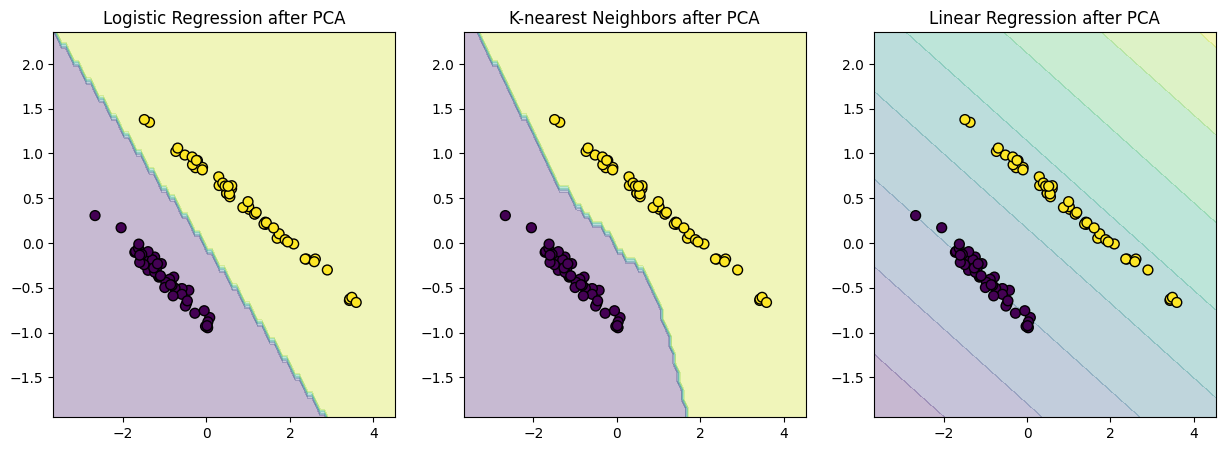

In [53]:
# Step 1: Generate synthetic data
n_samples = 100
n_features = 2
n_informative = 2  # Choose according to the total number of features
n_redundant = 0    # Choose according to the total number of features
n_repeated = 0     # Choose according to the total number of features
n_classes = 2
n_clusters_per_class = 1
random_state = 42

# Generate synthetic data
X, y = make_classification(n_samples=n_samples, n_features=n_features, n_informative=n_informative,
                           n_redundant=n_redundant, n_repeated=n_repeated, n_classes=n_classes,
                           n_clusters_per_class=n_clusters_per_class, random_state=random_state)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Train models after PCA
lr_model_pca = LogisticRegression()
lr_model_pca.fit(X_pca, y)

knn_model_pca = KNeighborsClassifier(n_neighbors=5)
knn_model_pca.fit(X_pca, y)

lr_pca_model = LinearRegression()
lr_pca_model.fit(X_pca, y)

# Plot decision boundaries
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

fig, axarr = plt.subplots(1, 3, figsize=(15, 5))

# Logistic Regression decision boundary after PCA
Z_lr_pca = lr_model_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z_lr_pca = Z_lr_pca.reshape(xx.shape)
axarr[0].contourf(xx, yy, Z_lr_pca, alpha=0.3)
axarr[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=50, edgecolor='k')
axarr[0].set_title('Logistic Regression after PCA')

# K-nearest Neighbors decision boundary after PCA
Z_knn_pca = knn_model_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z_knn_pca = Z_knn_pca.reshape(xx.shape)
axarr[1].contourf(xx, yy, Z_knn_pca, alpha=0.3)
axarr[1].scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=50, edgecolor='k')
axarr[1].set_title('K-nearest Neighbors after PCA')

# Linear Regression decision boundary after PCA
Z_lr_regr = lr_pca_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z_lr_regr = Z_lr_regr.reshape(xx.shape)
axarr[2].contourf(xx, yy, Z_lr_regr, alpha=0.3)
axarr[2].scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=50, edgecolor='k')
axarr[2].set_title('Linear Regression after PCA')

plt.show()

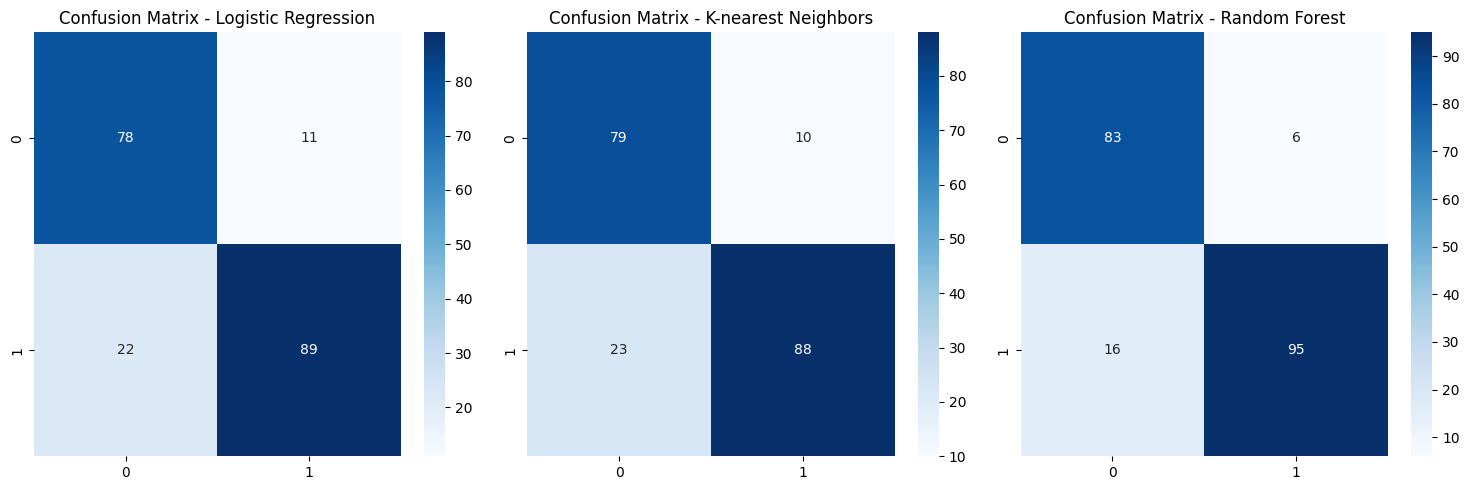

In [44]:
# Generate synthetic data
X, y = make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=42)

# Apply PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Train classifiers
lr_model = LogisticRegression()
knn_model = KNeighborsClassifier(n_neighbors=5)
rf_model = RandomForestClassifier(n_estimators=100)

lr_model.fit(X_train, y_train)
knn_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Predict classes
y_pred_lr = lr_model.predict(X_test)
y_pred_knn = knn_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Compute confusion matrices
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plot confusion matrices
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')

plt.subplot(1, 3, 2)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - K-nearest Neighbors')

plt.subplot(1, 3, 3)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')

plt.tight_layout()
plt.show()

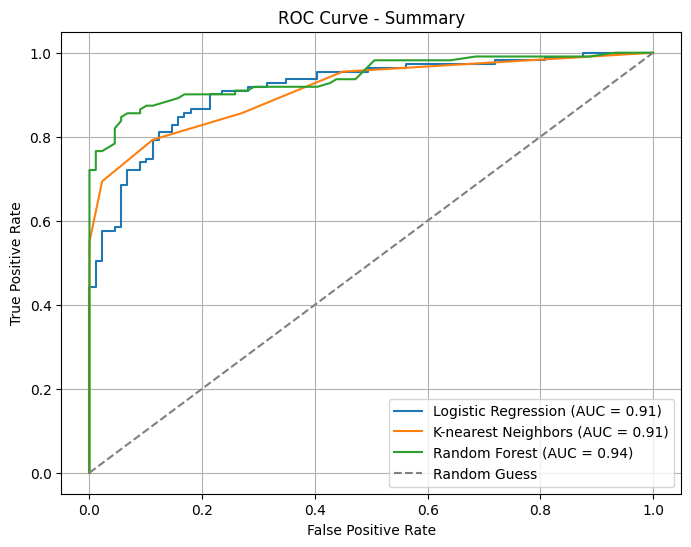

In [48]:
# Generate synthetic data
X, y = make_classification(n_samples=1000, n_features=10, n_classes=2, random_state=42)

# Apply PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Train classifiers
lr_model = LogisticRegression()
knn_model = KNeighborsClassifier(n_neighbors=5)
rf_model = RandomForestClassifier(n_estimators=100)

lr_model.fit(X_train, y_train)
knn_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Define classifiers and their predicted probabilities
classifiers = {
    'Logistic Regression': lr_model,
    'K-nearest Neighbors': knn_model,
    'Random Forest': rf_model
}

plt.figure(figsize=(8, 6))

# Plot ROC curves for each classifier
for name, clf in classifiers.items():
    # Get predicted probabilities for positive class
    y_prob = clf.predict_proba(X_test)[:, 1]
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    # Compute AUC
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')

# Set plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Summary')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

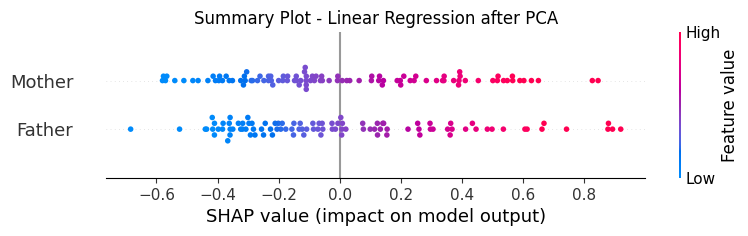

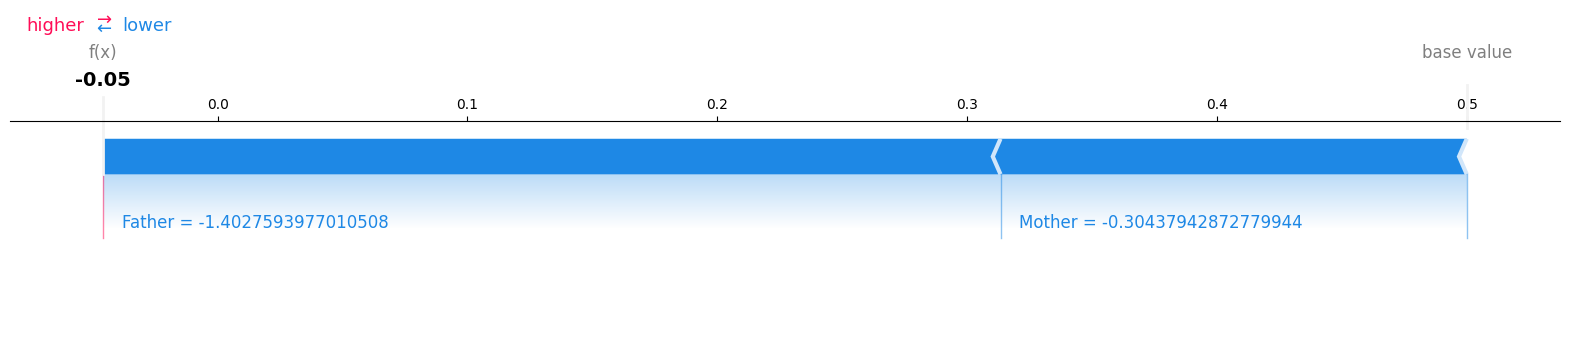

In [49]:
# Generate synthetic data
X, y = make_classification(n_samples=n_samples, n_features=n_features, n_informative=n_informative,
                           n_redundant=n_redundant, n_repeated=n_repeated, n_classes=n_classes,
                           n_clusters_per_class=n_clusters_per_class, random_state=random_state)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Train linear regression model after PCA
lr_pca_model = LinearRegression()
lr_pca_model.fit(X_pca, y)

# Initialize SHAP Explainer for linear regression model
lr_regr_explainer = shap.Explainer(lr_pca_model, X_pca)

# Compute SHAP values for linear regression model
lr_regr_shap_values = lr_regr_explainer.shap_values(X_pca)

# Generate summary plot for Linear Regression model after PCA
shap.summary_plot(lr_regr_shap_values, X_pca, feature_names=["Father", "Mother"], show=False)
plt.title("Summary Plot - Linear Regression after PCA")
plt.show()

# Select a single observation for force plot
sample_idx = 1  # Change the index as needed

# Generate force plot for Linear Regression model after PCA for a single observation
shap.force_plot(lr_regr_explainer.expected_value, lr_regr_shap_values[sample_idx], X_pca[sample_idx],
                feature_names=["Father", "Mother"], matplotlib=True)
plt.show()